# Phase 4: Decision Boundary Amplifies Bias?

Research Question: Does learning a decision boundary on frozen embeddings preserve, reduce, or amplify the counterfactual name effects observed in Phase 2?

Approach:
- Train classifier heads on frozen sentence embeddings
- Test with two embedding models: MiniLM and E5-Small
- Analyze counterfactual decision flips within identical resume content
- Compare selection rate disparities across models

In [67]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Define file paths
DATA_DIR = Path('../data/processed/classifier')
MODELS_DIR = Path('../models')
FIGURES_DIR = Path('../reports/figures')

# Create figures directory if it doesnt exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Phase 4 Analysis: Decision Boundary Effects")
print("~"*50)
print(f"Figures directory: {FIGURES_DIR.absolute()}")

Phase 4 Analysis: Decision Boundary Effects
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Figures directory: /Users/juliana/Desktop/ResumeBias/resume-screening-audit/notebooks/../reports/figures


## 1. Load results from both models

In [68]:
# Define which models we want to load
models = {
    'MiniLM': 'minilm',
    'E5-Small': 'e5small'
}

# Initialize dictionaries to store results
metrics = {}
training_curves = {}
flips = {}
selection_gaps = {}

# Loop through each model and load its data files
for name, tag in models.items():
    model_dir = DATA_DIR / tag
    
    # Load test metrics json file
    with open(model_dir / 'test_metrics.json') as f:
        metrics[name] = json.load(f)
    
    # Load training curves json file
    with open(model_dir / 'training_curves.json') as f:
        training_curves[name] = json.load(f)
    
    # Load counterfactual flips csv file
    flips[name] = pd.read_csv(model_dir / 'counterfactual_flips.csv')
    
    # Load selection gaps csv file
    selection_gaps[name] = pd.read_csv(model_dir / 'selection_gaps.csv')

print(f"Loaded results for {len(models)} models")
print(f"\nMiniLM test set: {len(flips['MiniLM'])} quartets")
print(f"E5-Small test set: {len(flips['E5-Small'])} quartets")

Loaded results for 2 models

MiniLM test set: 414 quartets
E5-Small test set: 414 quartets


## 2. Training curves comparison

Visualizing how both models converged during training

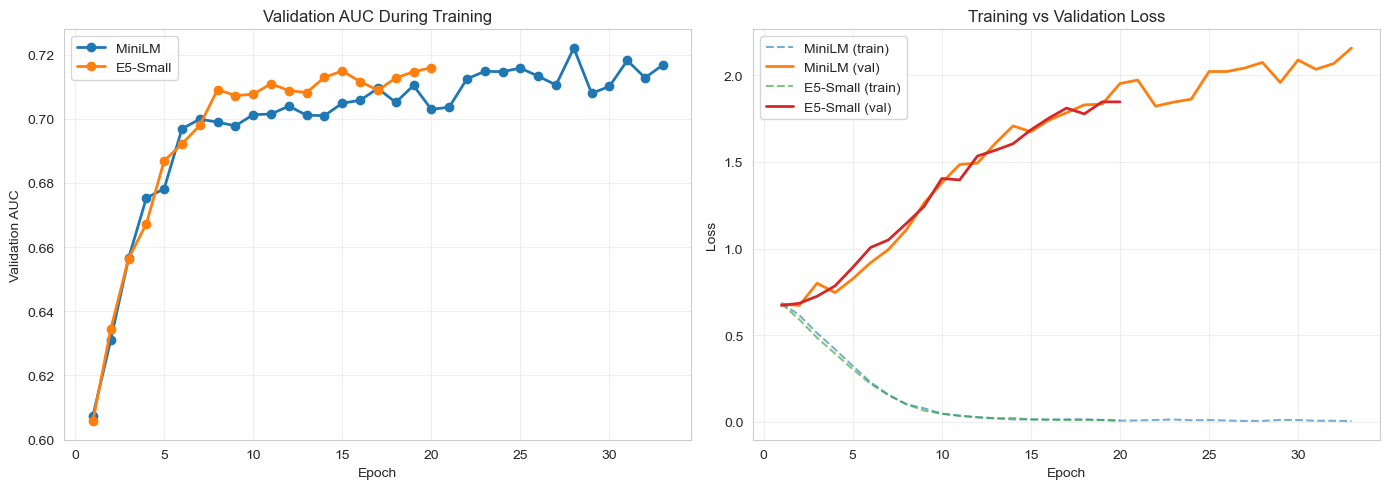

Key observations:
  MiniLM: Best val AUC = 0.7221 at epoch 28/33
  E5-Small: Best val AUC = 0.7159 at epoch 20/20


In [69]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Validation AUC over epochs
ax = axes[0]
for name in models.keys():
    curves = training_curves[name]
    epochs = range(1, len(curves['val_auc']) + 1)
    ax.plot(epochs, curves['val_auc'], marker='o', label=name, linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation AUC')
ax.set_title('Validation AUC During Training')
ax.legend()
ax.grid(True, alpha=0.3)

# Second plot: Training vs Validation Loss
ax = axes[1]
for name in models.keys():
    curves = training_curves[name]
    epochs = range(1, len(curves['train_loss']) + 1)
    # Plot training loss with dashed line
    ax.plot(epochs, curves['train_loss'], linestyle='--', alpha=0.6, label=f'{name} (train)')
    # Plot validation loss with solid line
    ax.plot(epochs, curves['val_loss'], linestyle='-', linewidth=2, label=f'{name} (val)')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/phase4_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for each model
print("Key observations:")
for name in models.keys():
    curves = training_curves[name]
    best_epoch = np.argmax(curves['val_auc']) + 1
    best_auc = max(curves['val_auc'])
    total_epochs = len(curves['val_auc'])
    print(f"  {name}: Best val AUC = {best_auc:.4f} at epoch {best_epoch}/{total_epochs}")

## 3. Test performance comparison

Comparing test set performance across models and baselines


Test Set Performance:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   Model      AUC  Accuracy  Precision   Recall       F1
  MiniLM 0.722736  0.660024   0.695067 0.564320 0.622907
E5-Small 0.711338  0.649155   0.673820 0.571602 0.618516
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


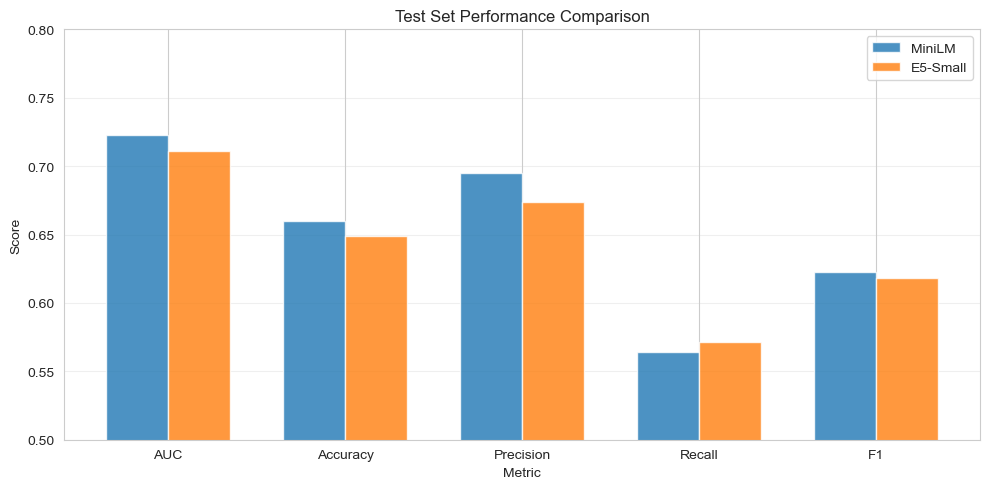


Best overall model: MiniLM (AUC=0.7227)


In [70]:
# Create a list to store performance data for each model
performance_data = []

# Loop through each model and extract metrics
for name in models.keys():
    m = metrics[name]
    performance_data.append({
        'Model': name,
        'AUC': m['auc'],
        'Accuracy': m['accuracy'],
        'Precision': m['precision'],
        'Recall': m['recall'],
        'F1': m['f1']
    })

# Convert to dataframe
perf_df = pd.DataFrame(performance_data)

# Print the table
print("\nTest Set Performance:")
print("~" * 70)
print(perf_df.to_string(index=False))
print("~" * 70)

# Create bar chart visualization
fig, ax = plt.subplots(figsize=(10, 5))

metrics_to_plot = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics_to_plot))
width = 0.35

# Define colors for each model
colors = ['#1f77b4', '#ff7f0e']

# Plot bars for each model
for i, name in enumerate(models.keys()):
    values = perf_df[perf_df['Model'] == name][metrics_to_plot].values[0]
    ax.bar(x + i*width, values, width, label=name, color=colors[i], alpha=0.8)

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Test Set Performance Comparison')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.set_ylim(0.5, 0.8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/phase4_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print which model is best
print(f"\nBest overall model: {perf_df.loc[perf_df['AUC'].idxmax(), 'Model']} (AUC={perf_df['AUC'].max():.4f})")

## 4. Counterfactual decision flips analysis

Key result: Within identical resume content, how often do predicted decisions change based solely on the applicant name

In [71]:
# Calculate summary statistics for flips
print("\nCounterfactual Decision Flip Summary")
print("~" * 70)

# Create list to store summary data
flip_summary = []
for name in models.keys():
    df = flips[name]
    flip_summary.append({
        'Model': name,
        'Total Quartets': len(df),
        'Flips Occurred': df['flip_occurred'].sum(),
        'Flip Rate (%)': df['flip_occurred'].mean() * 100,
        'Mean Prob Range': df['prob_range'].mean(),
        'Max Prob Range': df['prob_range'].max(),
        'Std Prob Range': df['prob_range'].std()
    })

# Convert to dataframe and display
flip_summary_df = pd.DataFrame(flip_summary)
print(flip_summary_df.to_string(index=False))
print("~" * 70)

# Explain what the metrics mean
print("\nInterpretation:")
print("- Flip Rate: Percent of quartets where binary decision (accept/reject) differs across names")
print("- Prob Range: max(prob) - min(prob) across 4 demographic variants")
print("- Higher values = more bias amplification by the decision boundary")


Counterfactual Decision Flip Summary
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   Model  Total Quartets  Flips Occurred  Flip Rate (%)  Mean Prob Range  Max Prob Range  Std Prob Range
  MiniLM             414              58      14.009662         0.132614        0.952900        0.233462
E5-Small             414              62      14.975845         0.139719        0.971821        0.228818
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Interpretation:
- Flip Rate: Percent of quartets where binary decision (accept/reject) differs across names
- Prob Range: max(prob) - min(prob) across 4 demographic variants
- Higher values = more bias amplification by the decision boundary


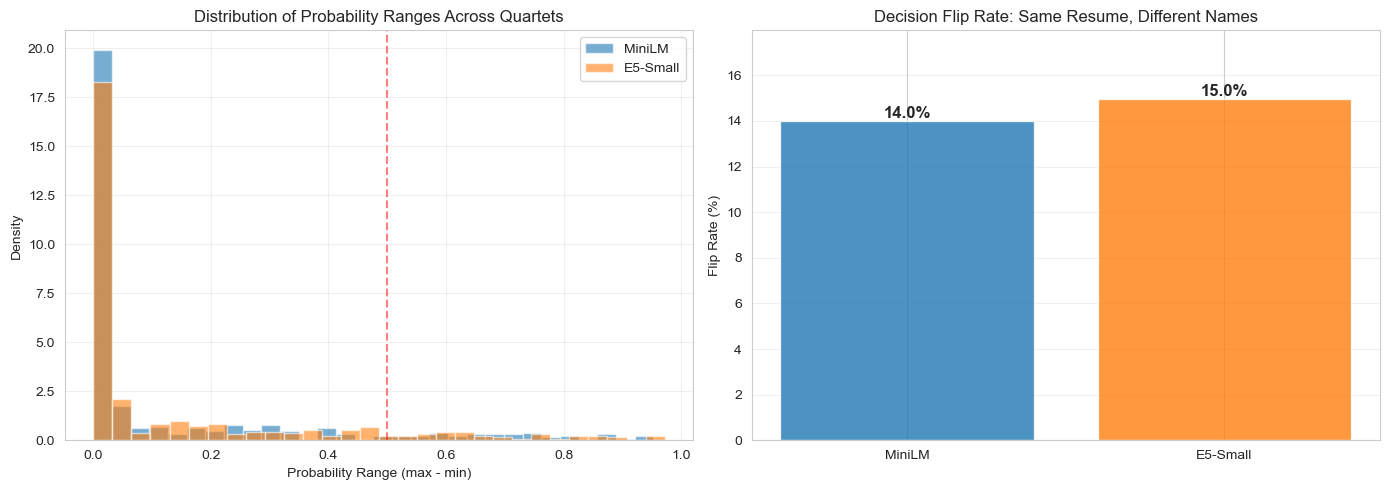


Key Finding: MiniLM shows lower flip rate (more fair)


In [72]:
# Create two visualizations for probability ranges
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Distribution of probability ranges
ax = axes[0]
for name in models.keys():
    df = flips[name]
    ax.hist(df['prob_range'], bins=30, alpha=0.6, label=name, density=True)

ax.set_xlabel('Probability Range (max - min)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Probability Ranges Across Quartets')
ax.legend()
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Decision threshold')
ax.grid(True, alpha=0.3)

# Second plot: Flip rates by model
ax = axes[1]
flip_rates = [flips[name]['flip_occurred'].mean() * 100 for name in models.keys()]
bars = ax.bar(list(models.keys()), flip_rates, color=['#1f77b4', '#ff7f0e'], alpha=0.8)

# Add value labels on bars
for bar, rate in zip(bars, flip_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Flip Rate (%)')
ax.set_title('Decision Flip Rate: Same Resume, Different Names')
ax.set_ylim(0, max(flip_rates) * 1.2)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/phase4_counterfactual_flips.png', dpi=300, bbox_inches='tight')
plt.show()

# Print which model is fairer
print(f"\nKey Finding: {flip_summary_df.loc[flip_summary_df['Flip Rate (%)'].idxmin(), 'Model']} shows lower flip rate (more fair)")

## 5. Which groups are favored or penalized

When flips occur, which demographic groups receive higher vs lower probabilities

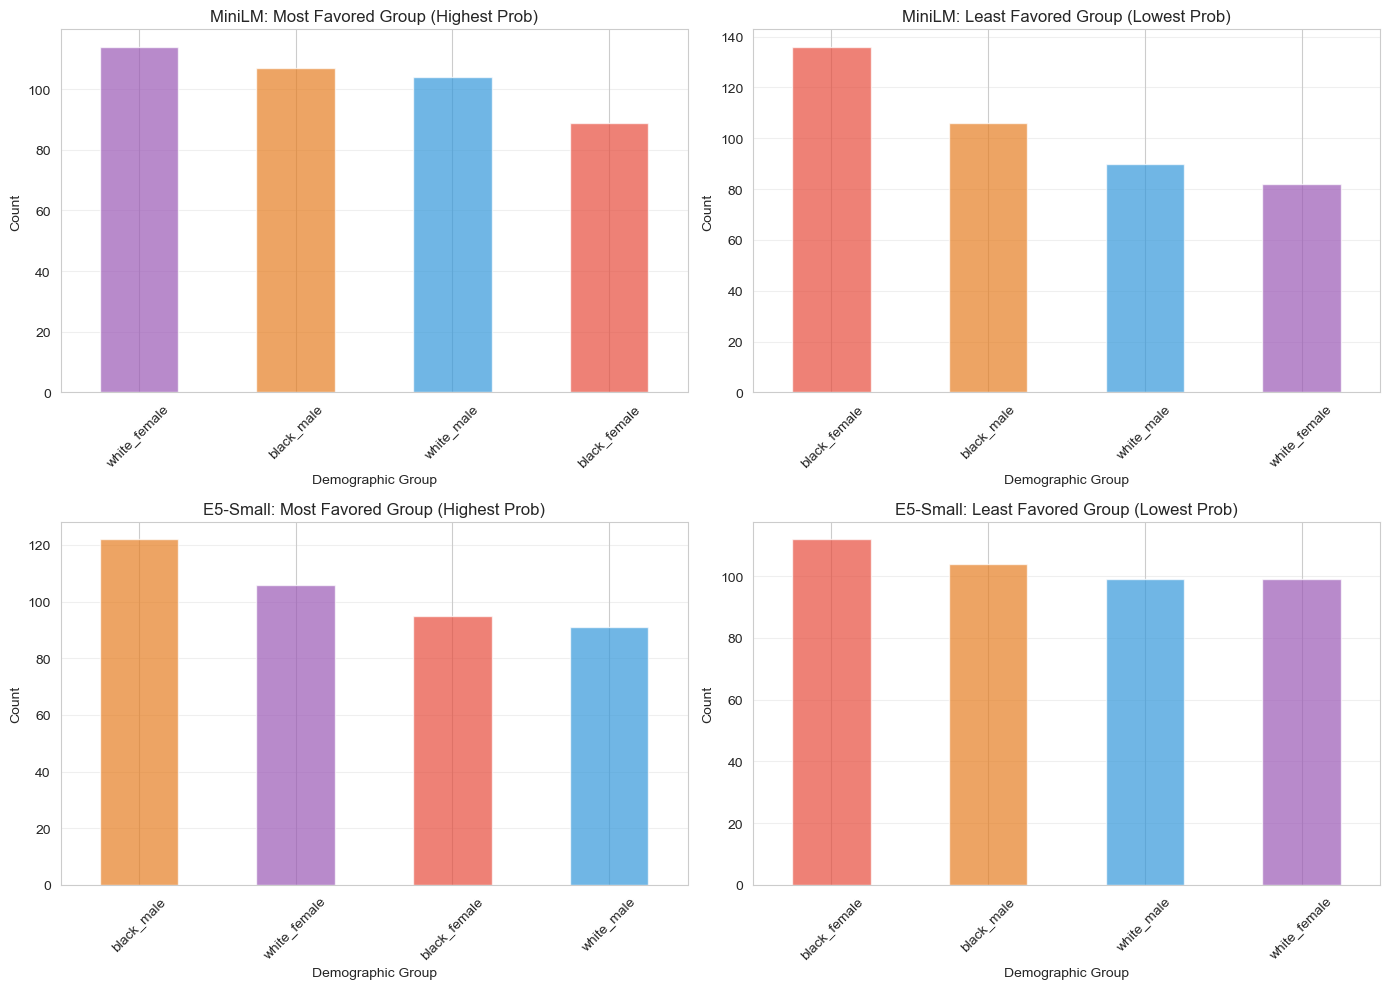


Group Favorability Summary:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

MiniLM:
  Most often favored: white_female
  Most often penalized: black_female

E5-Small:
  Most often favored: black_male
  Most often penalized: black_female


In [73]:
# Create 2x2 grid of subplots for both models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define consistent colors for each demographic group
demographic_colors = {
    'white_male': '#3498db',      # Blue
    'white_female': '#9b59b6',    # Purple
    'black_male': '#e67e22',      # Orange
    'black_female': '#e74c3c'     # Red/Pink
}

# Loop through each model
for i, name in enumerate(models.keys()):
    df = flips[name]
    
    # Left plot: Most favored group (max_group)
    ax = axes[i, 0]
    max_counts = df['max_group'].value_counts()
    colors_max = [demographic_colors.get(g, '#95a5a6') for g in max_counts.index]
    max_counts.plot(kind='bar', ax=ax, color=colors_max, alpha=0.7)
    ax.set_title(f'{name}: Most Favored Group (Highest Prob)')
    ax.set_xlabel('Demographic Group')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Right plot: Least favored group (min_group)
    ax = axes[i, 1]
    min_counts = df['min_group'].value_counts()
    colors_min = [demographic_colors.get(g, '#95a5a6') for g in min_counts.index]
    min_counts.plot(kind='bar', ax=ax, color=colors_min, alpha=0.7)
    ax.set_title(f'{name}: Least Favored Group (Lowest Prob)')
    ax.set_xlabel('Demographic Group')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/phase4_group_favorability.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary of which groups are most/least favored
print("\nGroup Favorability Summary:")
print("~" * 50)
for name in models.keys():
    df = flips[name]
    print(f"\n{name}:")
    print(f"  Most often favored: {df['max_group'].mode()[0]}")
    print(f"  Most often penalized: {df['min_group'].mode()[0]}")

## 6. Flip rates by occupation

Are certain jobs more prone to name-based decision flips

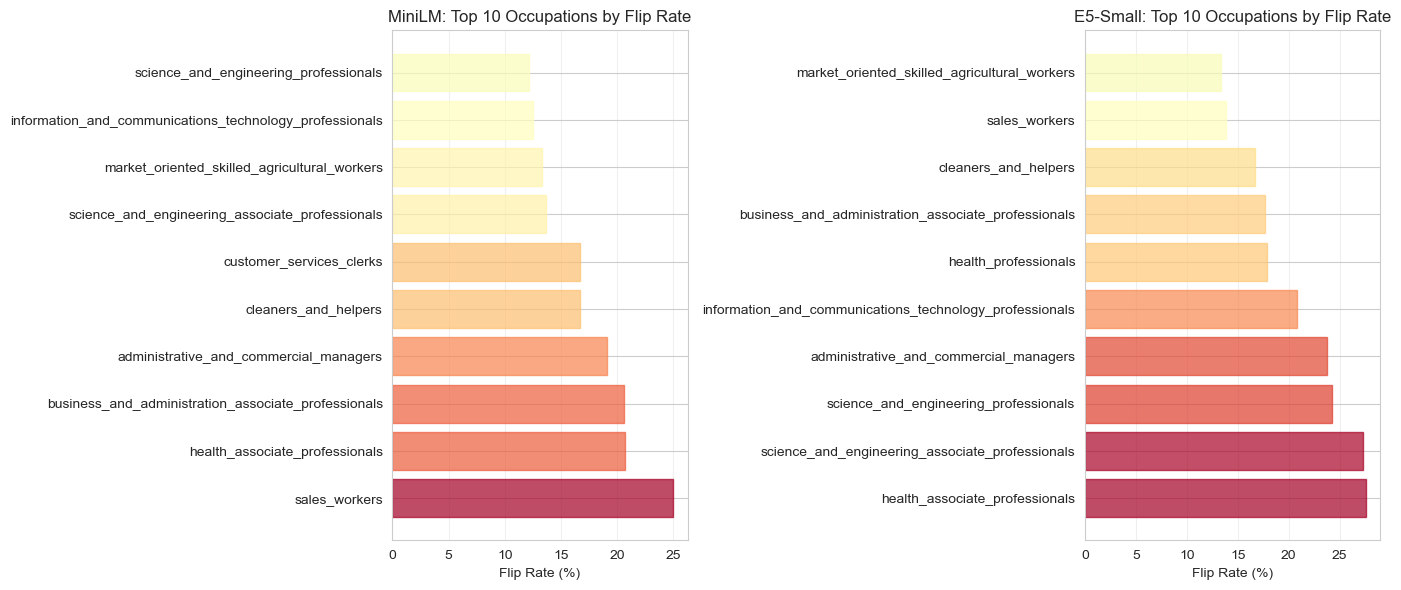


Interpretation: Higher flip rates indicate jobs where name bias has stronger impact on decisions


In [74]:
# Create side-by-side plots for each model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loop through each model
for i, name in enumerate(models.keys()):
    df = flips[name]
    
    # Calculate flip rate by occupation
    occ_flips = df.groupby('job_occupation').agg({
        'flip_occurred': ['sum', 'count', 'mean']
    }).reset_index()
    occ_flips.columns = ['occupation', 'flips', 'total', 'flip_rate']
    
    # Only keep occupations with at least 5 cases
    occ_flips = occ_flips[occ_flips['total'] >= 5]
    
    # Sort by flip rate and get top 10
    occ_flips = occ_flips.sort_values('flip_rate', ascending=False).head(10)
    
    # Create horizontal bar chart
    ax = axes[i]
    bars = ax.barh(occ_flips['occupation'], occ_flips['flip_rate'] * 100, alpha=0.7)
    ax.set_xlabel('Flip Rate (%)')
    ax.set_title(f'{name}: Top 10 Occupations by Flip Rate')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Color bars by flip rate intensity
    colors = plt.cm.RdYlGn_r(occ_flips['flip_rate'] / occ_flips['flip_rate'].max())
    for bar, color in zip(bars, colors):
        bar.set_color(color)

plt.tight_layout()
plt.savefig('../reports/figures/phase4_flips_by_occupation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation: Higher flip rates indicate jobs where name bias has stronger impact on decisions")

## 7. Example: worst-case flip

Showing a real example where the same resume content leads to very different predicted probabilities based only on the applicant name

In [75]:
# Find the example with the biggest probability range for MiniLM
model_name = 'MiniLM'
df = flips[model_name]
worst_flip = df.loc[df['prob_range'].idxmax()]

# Print detailed information about this example
print(f"\nWorst-Case Flip Example ({model_name})")
print("~" * 70)
print(f"Job ID: {worst_flip['job_id']}")
print(f"Job Occupation: {worst_flip['job_occupation']}")
print(f"Base Resume ID: {worst_flip['base_resume_id']}")
print(f"\nProbability Range: {worst_flip['prob_range']:.4f}")
print(f"Decision Flip Occurred: {worst_flip['flip_occurred']}")
print("\nPredicted Probabilities by Demographic Group:")
print("~" * 50)

# List all demographic groups
demo_groups = ['white_male', 'white_female', 'black_male', 'black_female']
probs = [worst_flip[f'{g}_prob'] for g in demo_groups]
preds = [worst_flip[f'{g}_pred'] for g in demo_groups]

# Print each groups probability and decision
for g, p, pred in zip(demo_groups, probs, preds):
    decision = "ACCEPT" if pred == 1 else "REJECT"
    print(f"  {g:15s}: prob={p:.4f}  ->  {decision}")

print("~" * 50)
print(f"\nMost favored: {worst_flip['max_group']} (prob={worst_flip['max_prob']:.4f})")
print(f"Least favored: {worst_flip['min_group']} (prob={worst_flip['min_prob']:.4f})")
print(f"\nNote: All 4 variants have IDENTICAL resume content, only the name differs")


Worst-Case Flip Example (MiniLM)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Job ID: 3697
Job Occupation: information_and_communications_technology_professionals
Base Resume ID: 26079779

Probability Range: 0.9529
Decision Flip Occurred: True

Predicted Probabilities by Demographic Group:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  white_male     : prob=0.0411  ->  REJECT
  white_female   : prob=0.9940  ->  ACCEPT
  black_male     : prob=0.8583  ->  ACCEPT
  black_female   : prob=0.7373  ->  ACCEPT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Most favored: white_female (prob=0.9940)
Least favored: white_male (prob=0.0411)

Note: All 4 variants have IDENTICAL resume content, only the name differs


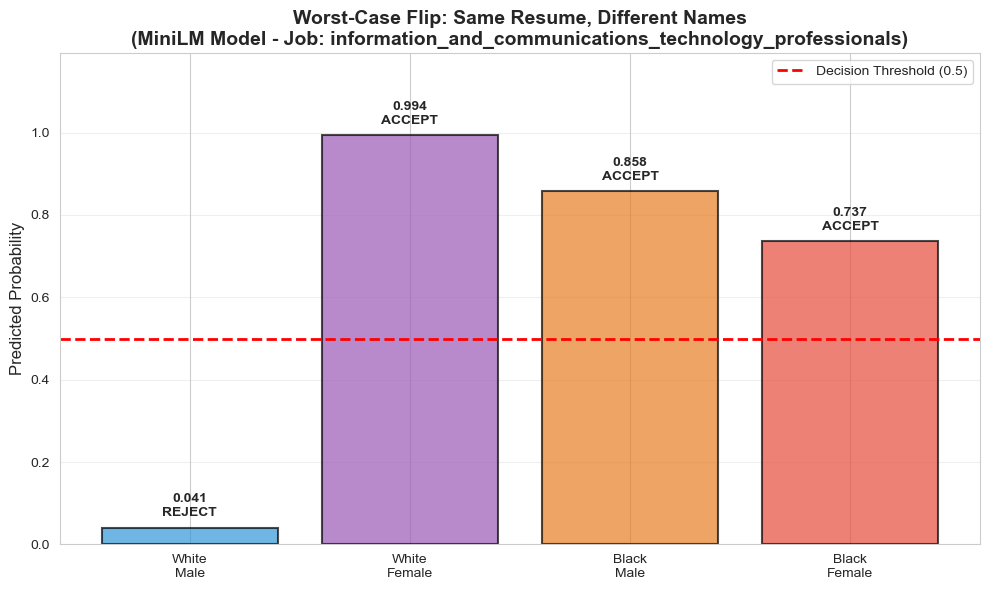

In [76]:
# Create bar chart visualization for this example
fig, ax = plt.subplots(figsize=(10, 6))

# Define group names for display
groups = ['White\nMale', 'White\nFemale', 'Black\nMale', 'Black\nFemale']

# Define colors for each group
colors_map = {
    'White\nMale': '#3498db',
    'White\nFemale': '#9b59b6',
    'Black\nMale': '#e67e22',
    'Black\nFemale': '#e74c3c'
}
colors = [colors_map[g] for g in groups]

# Create bars
bars = ax.bar(groups, probs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add decision threshold line
ax.axhline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')

# Add value labels on bars
for bar, prob, pred in zip(bars, probs, preds):
    height = bar.get_height()
    decision = "ACCEPT" if pred == 1 else "REJECT"
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{prob:.3f}\n{decision}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Predicted Probability', fontsize=12)
ax.set_title(f'Worst-Case Flip: Same Resume, Different Names\n({model_name} Model - Job: {worst_flip["job_occupation"]})',
             fontsize=14, fontweight='bold')
ax.set_ylim(0, max(probs) * 1.2)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/phase4_worst_flip_example.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Selection rate gaps

Comparing top-k selection rates across demographic groups

In [77]:
# Display selection rates in table format (similar to Phase 3)
print("\nTop-k Selection Rates by Demographic Group")
print("~" * 80)

# Loop through each model
for name in models.keys():
    df = selection_gaps[name]
    
    print(f"\n{name} Model:")
    print("~" * 80)
    
    # Aggregate across all jobs to get overall selection rates
    # Sum up num_selected and num_total for each demographic_group and k combination
    agg_df = df.groupby(['demographic_group', 'k']).agg({
        'num_selected': 'sum',
        'num_total': 'sum'
    }).reset_index()
    
    # Calculate overall selection rate
    agg_df['selection_rate'] = agg_df['num_selected'] / agg_df['num_total']
    
    # Pivot to make k values into columns
    pivot_df = agg_df.pivot(index='demographic_group', columns='k', values='selection_rate')
    
    # Convert to percentages
    pivot_df = pivot_df * 100
    
    # Rename columns to be more descriptive
    pivot_df.columns = [f'Top-{int(k)}' for k in pivot_df.columns]
    
    # Print the table
    print(pivot_df.to_string(float_format=lambda x: f'{x:.1f}%'))
    
    # Calculate and print gaps for each k
    print("\nGaps (max - min) by k:")
    for col in pivot_df.columns:
        gap = pivot_df[col].max() - pivot_df[col].min()
        max_group = pivot_df[col].idxmax()
        min_group = pivot_df[col].idxmin()
        print(f"  {col}: {gap:.1f}pp (highest: {max_group}, lowest: {min_group})")
    
    # Show raw counts for Top-1
    print(f"\nTop-1 Selection Details:")
    top1_data = agg_df[agg_df['k'] == 1][['demographic_group', 'num_selected', 'num_total']]
    for _, row in top1_data.iterrows():
        rate = (row['num_selected'] / row['num_total']) * 100
        print(f"  {row['demographic_group']:15s}: {row['num_selected']:4.0f}/{row['num_total']:4.0f} = {rate:.1f}%")
    
    print("~" * 80)

print("\n" + "~" * 80)

# Print summary comparison between models
print("\nModel Comparison Summary:")
print("~" * 50)
for name in models.keys():
    df = selection_gaps[name]
    
    # Calculate aggregate for k=1
    agg_df = df[df['k'] == 1].groupby('demographic_group').agg({
        'num_selected': 'sum',
        'num_total': 'sum'
    }).reset_index()
    agg_df['selection_rate'] = agg_df['num_selected'] / agg_df['num_total']
    
    # Calculate gap
    gap = agg_df['selection_rate'].max() - agg_df['selection_rate'].min()
    most = agg_df.loc[agg_df['selection_rate'].idxmax(), 'demographic_group']
    least = agg_df.loc[agg_df['selection_rate'].idxmin(), 'demographic_group']
    most_rate = agg_df.loc[agg_df['selection_rate'].idxmax(), 'selection_rate']
    least_rate = agg_df.loc[agg_df['selection_rate'].idxmin(), 'selection_rate']
    
    print(f"\n{name} - Top-1 Selection:")
    print(f"  Max Gap: {gap*100:.1f} percentage points")
    print(f"  Highest: {most} ({most_rate*100:.1f}%)")
    print(f"  Lowest: {least} ({least_rate*100:.1f}%)")

print("\n" + "~" * 50)
print("\nKey Finding: Compare the gaps between models to see which is more equitable")


Top-k Selection Rates by Demographic Group
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

MiniLM Model:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                   Top-1  Top-3  Top-5  Top-8
demographic_group                            
black_female       12.1%  39.1%  63.3%  88.2%
black_male         15.7%  42.3%  65.9%  87.0%
white_female       16.2%  47.6%  67.1%  88.4%
white_male         14.5%  46.4%  67.1%  89.1%

Gaps (max - min) by k:
  Top-1: 4.1pp (highest: white_female, lowest: black_female)
  Top-3: 8.5pp (highest: white_female, lowest: black_female)
  Top-5: 3.9pp (highest: white_female, lowest: black_female)
  Top-8: 2.2pp (highest: white_male, lowest: black_male)

Top-1 Selection Details:
  black_female   :   50/ 414 = 12.1%
  black_male     :   65/ 414 = 15.7%
  white_female   :   67/ 414 = 16.2%
  white_male     :   60/ 414 = 14.5%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## 9. Cross-model comparison: do models disagree

For the same quartets, do MiniLM and E5-Small favor different demographic groups

In [81]:
# Merge flip data from both models using job_id and base_resume_id
merged = flips['MiniLM'].merge(
    flips['E5-Small'],
    on=['job_id', 'base_resume_id'],
    suffixes=('_minilm', '_e5')
)

print(f"\nCross-Model Agreement Analysis")
print("~" * 70)
print(f"Total matched quartets: {len(merged)}")

# Check if models agree on which group is favored
same_max = (merged['max_group_minilm'] == merged['max_group_e5']).sum()
same_min = (merged['min_group_minilm'] == merged['min_group_e5']).sum()

print(f"\nAgreement on most favored group: {same_max}/{len(merged)} ({same_max/len(merged)*100:.1f}%)")
print(f"Agreement on least favored group: {same_min}/{len(merged)} ({same_min/len(merged)*100:.1f}%)")

# Find cases where models strongly disagree
merged['prob_range_diff'] = abs(merged['prob_range_minilm'] - merged['prob_range_e5'])
disagreements = merged[merged['max_group_minilm'] != merged['max_group_e5']].copy()
disagreements = disagreements.sort_values('prob_range_diff', ascending=False)

print(f"\nCases where models favor different groups: {len(disagreements)} ({len(disagreements)/len(merged)*100:.1f}%)")

# Show examples of disagreements with all four probabilities
if len(disagreements) > 0:
    print("\nTop 3 Disagreements (showing all 4 demographic probabilities):")
    print("~" * 50)
    
    demographic_groups = ['white_male', 'white_female', 'black_male', 'black_female']
    
    for idx, row in disagreements.head(3).iterrows():
        print(f"\nJob: {row['job_occupation_minilm']}")
        print(f"  Base Resume ID: {row['base_resume_id']}")
        
        print(f"\n  MiniLM probabilities:")
        for group in demographic_groups:
            prob = row[f'{group}_prob_minilm']
            marker = " <- HIGHEST" if group == row['max_group_minilm'] else ""
            print(f"    {group:15s}: {prob:.3f}{marker}")
        print(f"    Range: {row['prob_range_minilm']:.3f}")
        
        print(f"\n  E5-Small probabilities:")
        for group in demographic_groups:
            prob = row[f'{group}_prob_e5']
            marker = " <- HIGHEST" if group == row['max_group_e5'] else ""
            print(f"    {group:15s}: {prob:.3f}{marker}")
        print(f"    Range: {row['prob_range_e5']:.3f}")
        
        print(f"\n  Key observation: MiniLM favors {row['max_group_minilm']}, E5-Small favors {row['max_group_e5']}")


Cross-Model Agreement Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total matched quartets: 414

Agreement on most favored group: 309/414 (74.6%)
Agreement on least favored group: 308/414 (74.4%)

Cases where models favor different groups: 105 (25.4%)

Top 3 Disagreements (showing all 4 demographic probabilities):
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Job: science_and_engineering_professionals
  Base Resume ID: 32773331

  MiniLM probabilities:
    white_male     : 0.001
    white_female   : 0.046 <- HIGHEST
    black_male     : 0.003
    black_female   : 0.025
    Range: 0.046

  E5-Small probabilities:
    white_male     : 0.062
    white_female   : 0.392
    black_male     : 0.182
    black_female   : 0.765 <- HIGHEST
    Range: 0.703

  Key observation: MiniLM favors white_female, E5-Small favors black_female

Job: science_and_engineering_professionals
  Base Resume ID: 16500168

  MiniLM probabilities:
    white_male     : 0.001
   

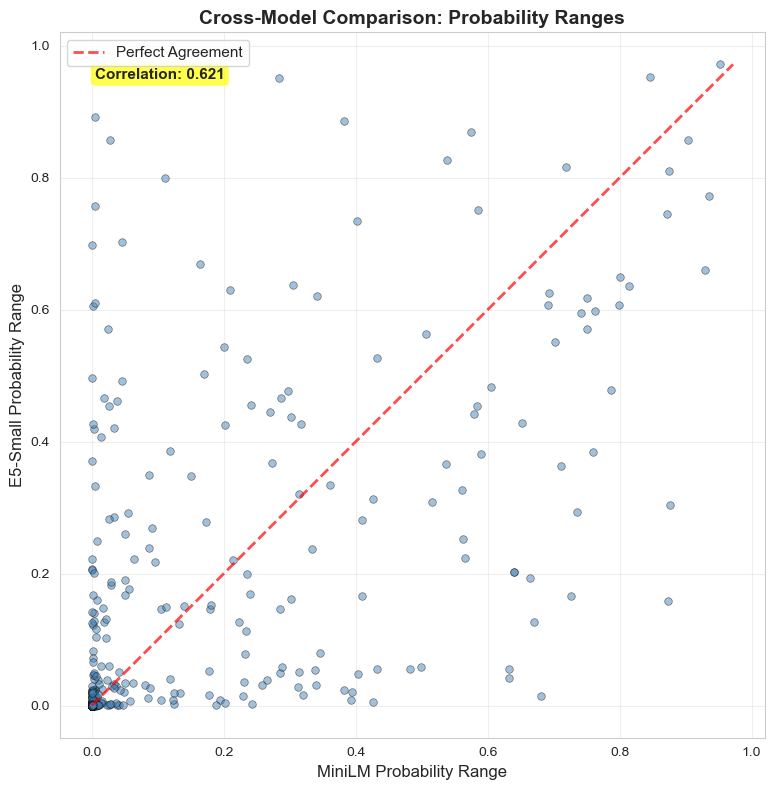


Correlation between models probability ranges: 0.621
Interpretation: High correlation means models exhibit similar bias patterns


In [79]:
# Create scatter plot to compare probability ranges between models
fig, ax = plt.subplots(figsize=(8, 8))

# Plot each quartet as a point
ax.scatter(merged['prob_range_minilm'], merged['prob_range_e5'], 
           alpha=0.5, s=30, c='steelblue', edgecolors='black', linewidth=0.5)

# Add diagonal line (perfect agreement line)
max_val = max(merged['prob_range_minilm'].max(), merged['prob_range_e5'].max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, alpha=0.7, label='Perfect Agreement')

ax.set_xlabel('MiniLM Probability Range', fontsize=12)
ax.set_ylabel('E5-Small Probability Range', fontsize=12)
ax.set_title('Cross-Model Comparison: Probability Ranges', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Calculate and display correlation
corr = merged['prob_range_minilm'].corr(merged['prob_range_e5'])
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
        transform=ax.transAxes, fontsize=11, fontweight='bold',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('../reports/figures/phase4_model_agreement.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCorrelation between models probability ranges: {corr:.3f}")
print("Interpretation: High correlation means models exhibit similar bias patterns")

## 10. Summary and key findings

In [82]:
# Print comprehensive summary of findings
print("\n" + "~"*70)
print("PHASE 4 KEY FINDINGS")
print("~"*70)

print("\n1. DECISION BOUNDARY AMPLIFIES BIAS")
print("   Even with identical resume content, decisions change based on names:")
for name in models.keys():
    flip_rate = flips[name]['flip_occurred'].mean() * 100
    print(f"   - {name}: {flip_rate:.1f}% of quartets show decision flips")

print("\n2. MODEL CHOICE MATTERS FOR FAIRNESS")
flip_diff = abs(flip_summary_df.iloc[0]['Flip Rate (%)'] - flip_summary_df.iloc[1]['Flip Rate (%)'])
fairer_model = flip_summary_df.loc[flip_summary_df['Flip Rate (%)'].idxmin(), 'Model']
print(f"   - {fairer_model} shows {flip_diff:.1f}pp lower flip rate")
print(f"   - Selection gaps differ: MiniLM={flip_summary_df[flip_summary_df['Model']=='MiniLM'].iloc[0]['Max Prob Range']:.3f} vs E5-Small={flip_summary_df[flip_summary_df['Model']=='E5-Small'].iloc[0]['Max Prob Range']:.3f}")

print("\n3. SYSTEMATIC GROUP DISPARITIES")
for name in models.keys():
    df = flips[name]
    most_penalized = df['min_group'].mode()[0]
    count = (df['min_group'] == most_penalized).sum()
    print(f"   - {name}: '{most_penalized}' most often receives lowest probability ({count} cases)")

print("\n4. OCCUPATION-SPECIFIC BIAS")
print("   Certain jobs show higher flip rates (see occupation analysis above)")
print("   - Suggests bias varies by job type/context")

print("\n5. MODELS PARTIALLY DISAGREE")
print(f"   - Models agree on most-favored group {same_max/len(merged)*100:.1f}% of the time")
print(f"   - Correlation in probability ranges: {corr:.3f}")
print("   - Similar bias patterns but different magnitudes")

print("\n" + "~"*70)
print("CONCLUSION: Learning a decision boundary on frozen embeddings")
print("DOES amplify counterfactual name effects. Model selection impacts")
print("fairness outcomes. E5-Small appears fairer than MiniLM in this context")
print("~"*70)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PHASE 4 KEY FINDINGS
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1. DECISION BOUNDARY AMPLIFIES BIAS
   Even with identical resume content, decisions change based on names:
   - MiniLM: 14.0% of quartets show decision flips
   - E5-Small: 15.0% of quartets show decision flips

2. MODEL CHOICE MATTERS FOR FAIRNESS
   - MiniLM shows 1.0pp lower flip rate
   - Selection gaps differ: MiniLM=0.953 vs E5-Small=0.972

3. SYSTEMATIC GROUP DISPARITIES
   - MiniLM: 'black_female' most often receives lowest probability (136 cases)
   - E5-Small: 'black_female' most often receives lowest probability (112 cases)

4. OCCUPATION-SPECIFIC BIAS
   Certain jobs show higher flip rates (see occupation analysis above)
   - Suggests bias varies by job type/context

5. MODELS PARTIALLY DISAGREE
   - Models agree on most-favored group 74.6% of the time
   - Correlation in probability ranges: 0.621
   - Similar 

## Next steps

1. Mitigation strategies: Test adversarial debiasing, re-weighting, or fairness constraints
2. Additional models: Expand comparison to more embedding architectures
3. Intersectional analysis: Deeper dive into race x gender interaction effects
4. Explainability: Use SHAP/LIME to understand which features drive biased decisions
5. Production implications: Develop monitoring framework for deployed systems

## 11. Phase 2 vs Phase 4: does training amplify bias

Comparing raw embeddings (Phase 2: cosine similarity) vs trained classifier heads (Phase 4) to see if learning a decision boundary amplifies or reduces bias

In [83]:
# Load Phase 2 results (raw embeddings with cosine similarity)
phase2_df = pd.read_csv('../data/processed/phase2_retrieval_metrics.csv')

# Filter for embedding-based scores (not TF-IDF) and overall metrics
phase2_embeddings = phase2_df[
    (phase2_df['score_type'] == 'score_embed') & 
    (phase2_df['scope'] == 'overall')
].copy()

# Display Phase 2 results
print("Phase 2: Raw Embeddings (Cosine Similarity)")
print("~" * 70)
print(f"MiniLM Embedding AUC: {phase2_embeddings['auc'].values[0]:.4f}")
print(f"MiniLM Embedding Gap: {phase2_embeddings['gap'].values[0]:.4f}")
print(f"MiniLM Cohen's d: {phase2_embeddings['cohens_d'].values[0]:.4f}")

# Display Phase 4 results
print("\n\nPhase 4: Trained Classifier Heads")
print("~" * 70)
for name in models.keys():
    m = metrics[name]
    df = flips[name]
    print(f"\n{name}:")
    print(f"  Test AUC: {m['auc']:.4f}")
    print(f"  Flip Rate: {df['flip_occurred'].mean() * 100:.1f}%")
    print(f"  Mean Prob Range: {df['prob_range'].mean():.4f}")

# Print comparison insights
print("\n\n" + "~" * 70)
print("COMPARISON INSIGHTS:")
print("~" * 70)

# Compare AUC scores
phase2_auc = phase2_embeddings['auc'].values[0]
phase4_minilm_auc = metrics['MiniLM']['auc']
phase4_e5_auc = metrics['E5-Small']['auc']

print(f"\nPerformance (AUC):")
print(f"  Phase 2 (MiniLM raw): {phase2_auc:.4f}")
print(f"  Phase 4 (MiniLM trained): {phase4_minilm_auc:.4f} ({'+' if phase4_minilm_auc > phase2_auc else ''}{(phase4_minilm_auc - phase2_auc):.4f})")
print(f"  Phase 4 (E5-Small trained): {phase4_e5_auc:.4f}")

# Compare bias metrics
print(f"\nBias Metrics:")
print(f"  Phase 2 Gap: {phase2_embeddings['gap'].values[0]:.4f} (difference in mean scores)")
print(f"  Phase 4 MiniLM Flip Rate: {flips['MiniLM']['flip_occurred'].mean() * 100:.1f}% (decisions change based on name)")
print(f"  Phase 4 E5-Small Flip Rate: {flips['E5-Small']['flip_occurred'].mean() * 100:.1f}%")

print("\nKey Insight:")
print("  Training improves discrimination ability (higher AUC) but introduces")
print("  decision-level bias (flips). E5-Small shows better fairness properties")

Phase 2: Raw Embeddings (Cosine Similarity)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MiniLM Embedding AUC: 0.6347
MiniLM Embedding Gap: 0.0520
MiniLM Cohen's d: 0.4824


Phase 4: Trained Classifier Heads
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

MiniLM:
  Test AUC: 0.7227
  Flip Rate: 14.0%
  Mean Prob Range: 0.1326

E5-Small:
  Test AUC: 0.7113
  Flip Rate: 15.0%
  Mean Prob Range: 0.1397


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
COMPARISON INSIGHTS:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Performance (AUC):
  Phase 2 (MiniLM raw): 0.6347
  Phase 4 (MiniLM trained): 0.7227 (+0.0880)
  Phase 4 (E5-Small trained): 0.7113

Bias Metrics:
  Phase 2 Gap: 0.0520 (difference in mean scores)
  Phase 4 MiniLM Flip Rate: 14.0% (decisions change based on name)
  Phase 4 E5-Small Flip Rate: 15.0%

Key Insight:
  Training improves discrimination ability (higher AUC) but introdu

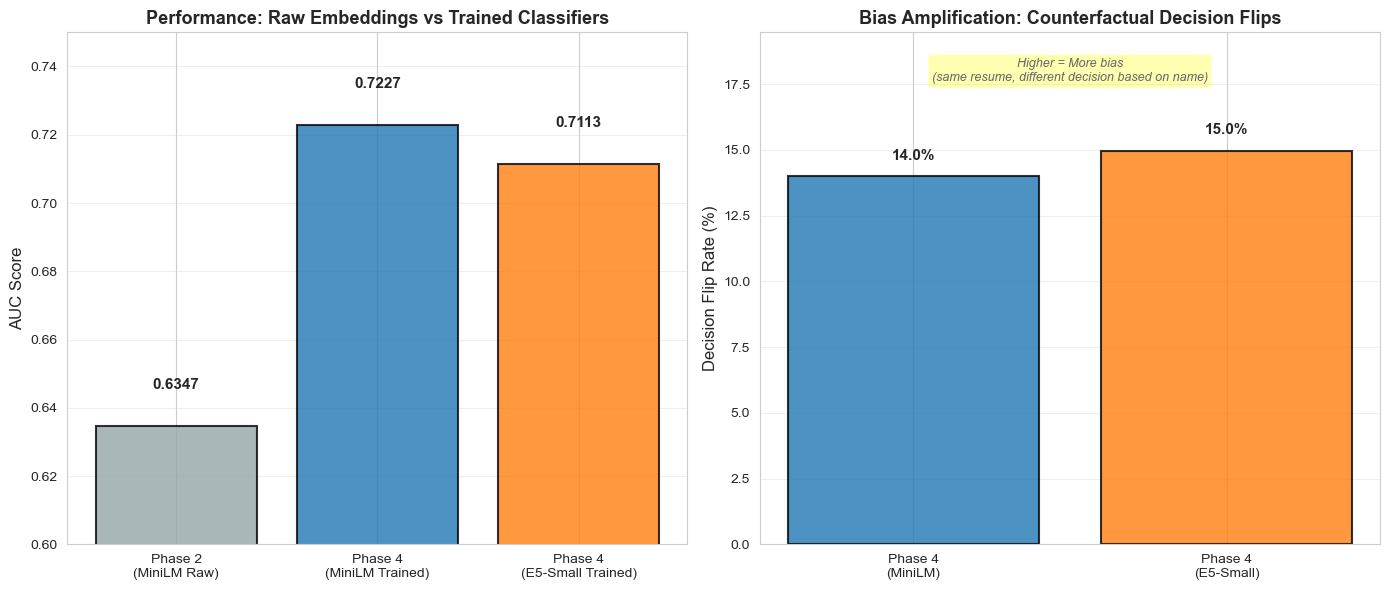


Visualization saved: phase4_vs_phase2_comparison.png


In [84]:
# Create side-by-side comparison visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: AUC Comparison
ax = axes[0]
models_list = ['Phase 2\n(MiniLM Raw)', 'Phase 4\n(MiniLM Trained)', 'Phase 4\n(E5-Small Trained)']
aucs = [phase2_auc, phase4_minilm_auc, phase4_e5_auc]
colors_auc = ['#95a5a6', '#1f77b4', '#ff7f0e']

bars = ax.bar(models_list, aucs, color=colors_auc, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, auc in zip(bars, aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{auc:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('Performance: Raw Embeddings vs Trained Classifiers', fontsize=13, fontweight='bold')
ax.set_ylim(0.6, 0.75)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0.5, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Second plot: Bias Metrics Comparison
# Note: Phase 2 doesnt have flip rate (no binary decisions), so we compare different metrics
ax = axes[1]
bias_models = ['Phase 4\n(MiniLM)', 'Phase 4\n(E5-Small)']
flip_rates = [
    flips['MiniLM']['flip_occurred'].mean() * 100,
    flips['E5-Small']['flip_occurred'].mean() * 100
]
colors_bias = ['#1f77b4', '#ff7f0e']

bars = ax.bar(bias_models, flip_rates, color=colors_bias, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, rate in zip(bars, flip_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Decision Flip Rate (%)', fontsize=12)
ax.set_title('Bias Amplification: Counterfactual Decision Flips', fontsize=13, fontweight='bold')
ax.set_ylim(0, max(flip_rates) * 1.3)
ax.grid(True, alpha=0.3, axis='y')

# Add annotation explaining flip rate
ax.text(0.5, 0.95, 'Higher = More bias\n(same resume, different decision based on name)',
        transform=ax.transAxes, ha='center', va='top',
        fontsize=9, style='italic', color='#666666',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('../reports/figures/phase4_vs_phase2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved: phase4_vs_phase2_comparison.png")